# Proyek Klasifikasi Gambar: [Cards Image Dataset]
- **Nama:** [Ryan Rachmad Hidayat]
- **Email:** [ryan.rachmad.works@gmail.com]
- **ID Dicoding:** [ryan_rachmad_hidayat]

## Import Semua Packages/Library yang Digunakan

In [1]:
import subprocess
import sys

def install_package(package):
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package],
            stdout=subprocess.DEVNULL,  # Nonaktifkan output
            stderr=subprocess.DEVNULL
        )
        print("Done")
    except subprocess.CalledProcessError:
        print("Gagal install:", package)

# Install googletrans versi yang stabil
install_package("tensorflowjs")

Done


In [2]:
import kagglehub
import keras
import tqdm
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Input, Flatten, Concatenate
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
import tensorflowjs as tfjs
from sklearn.utils import shuffle
from keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5
warnings.simplefilter("ignore")

print(tfjs.__version__) # Cek versi dari Tensorflow.js
print(tf.__version__) # Cek versi dari Tensorflow

4.22.0
2.18.0


## Data Preparation

### Data Loading

In [3]:
# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cards-image-datasetclassification


In [4]:
trainDir = '/kaggle/input/cards-image-datasetclassification/train'
testDir = '/kaggle/input/cards-image-datasetclassification/test'
valDir = '/kaggle/input/cards-image-datasetclassification/valid'
trainFolders = os.listdir(trainDir)
testFolders = os.listdir(testDir)
valFolders = os.listdir(valDir)

In [5]:
def load_images(folders) :
  folderPics = []
  y = []
  for fol in tqdm.tqdm(folders) :
    for image in os.listdir(os.path.join(trainDir,fol)) :
      imgPath = os.path.join(trainDir,fol,image)
      img = cv2.imread(imgPath)
      imgRGB = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
      imgRGB = cv2.resize(imgRGB, (70,70))
      folderPics.append(imgRGB)
      y.append(fol)
  return folderPics , y

In [6]:
df = pd.read_csv('/kaggle/input/cards-image-datasetclassification/cards.csv')
df

,class index,filepaths,labels,card type,data set
0,0,train/ace of clubs/001.jpg,ace of clubs,ace,train
1,0,train/ace of clubs/002.jpg,ace of clubs,ace,train
...,...,...,...,...,...
8153,52,valid/two of spades/4.jpg,two of spades,two,valid
8154,52,valid/two of spades/5.jpg,two of spades,two,valid


### Data Preprocessing

#### Split Dataset

In [7]:
x , y = load_images(trainFolders)
xtest , ytest = load_images(testFolders)
xval , yval = load_images(valFolders)

x_Shuffled , y_Shuffled = shuffle(x,y,random_state = 123)
xtest_Shuffled , ytest_Shuffled = shuffle(x,y,random_state = 123)
xval_Shuffled , yval_Shuffled = shuffle(x,y,random_state = 123)

x_train = np.array(x_Shuffled)
x_test = np.array(xtest_Shuffled)
x_val = np.array(xval_Shuffled)

x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape(-1,70,70,3)
x_test = x_test.reshape(-1,70,70,3)
x_val = x_val.reshape(-1,70,70,3)

cats = df.labels.value_counts().index
categories = {}
for i,c in enumerate(cats) :
  categories[c]=i

for i in range(len(y_Shuffled)) :
  y_Shuffled[i] = categories[y_Shuffled[i]]

for i in range(len(ytest_Shuffled)) :
  ytest_Shuffled[i] = categories[ytest_Shuffled[i]]

for i in range(len(yval_Shuffled)) :
  yval_Shuffled[i] = categories[yval_Shuffled[i]]

y_test = np.array(ytest_Shuffled)
y_val = np.array(yval_Shuffled)

y_train = to_categorical(y_Shuffled)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

100%|██████████| 53/53 [00:12<00:00,  4.18it/s]


## Modelling

In [8]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs['accuracy'] > 0.95 and logs['val_accuracy'] > 0.95:
                print("\nReached 95% training accuracy and 95% validation accuracy, so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [9]:
model = Sequential([
    Conv2D(32 , (3,3) , activation='relu' , input_shape=(70,70,3)),
    MaxPooling2D((2,2)),
    Conv2D(32 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Conv2D(32 , (3,3) , activation='relu' ),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128 , activation = 'relu'),
    Dense(64 , activation = 'relu'),
    Dense(53 , activation = 'softmax')
])

model.compile(optimizer='adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("best_model_acc.weights.h5", monitor='accuracy', verbose=1, save_best_only=True, mode='max', save_weights_only=True)

history1 = model.fit(x_train,y_train,validation_data= (x_val,y_val), epochs = 100, callbacks=[callbacks, checkpoint])

Epoch 1/100
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.0596 - loss: 3.7662
Epoch 1: accuracy improved from -inf to 0.14126, saving model to best_model_acc.weights.h5
239/239 ━━━━━━━━━━━━━━━━━━━━ 56s 223ms/step - accuracy: 0.0603 - loss: 3.7625 - val_accuracy: 0.3315 - val_loss: 2.3291
Epoch 2/100
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3581 - loss: 2.2289
Epoch 2: accuracy improved from 0.14126 to 0.37382, saving model to best_model_acc.weights.h5
239/239 ━━━━━━━━━━━━━━━━━━━━ 88s 250ms/step - accuracy: 0.3582 - loss: 2.2282 - val_accuracy: 0.4533 - val_loss: 1.8501
Epoch 3/100
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.4885 - loss: 1.7432
Epoch 3: accuracy improved from 0.37382 to 0.50866, saving model to best_model_acc.weights.h5
239/239 ━━━━━━━━━━━━━━━━━━━━ 73s 214ms/step - accuracy: 0.4886 - loss: 1.7430 - val_accuracy: 0.6062 - val_loss: 1.4198
Epoch 4/100
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.5960 - loss: 1.4230
Epoch

## Evaluasi dan Visualisasi

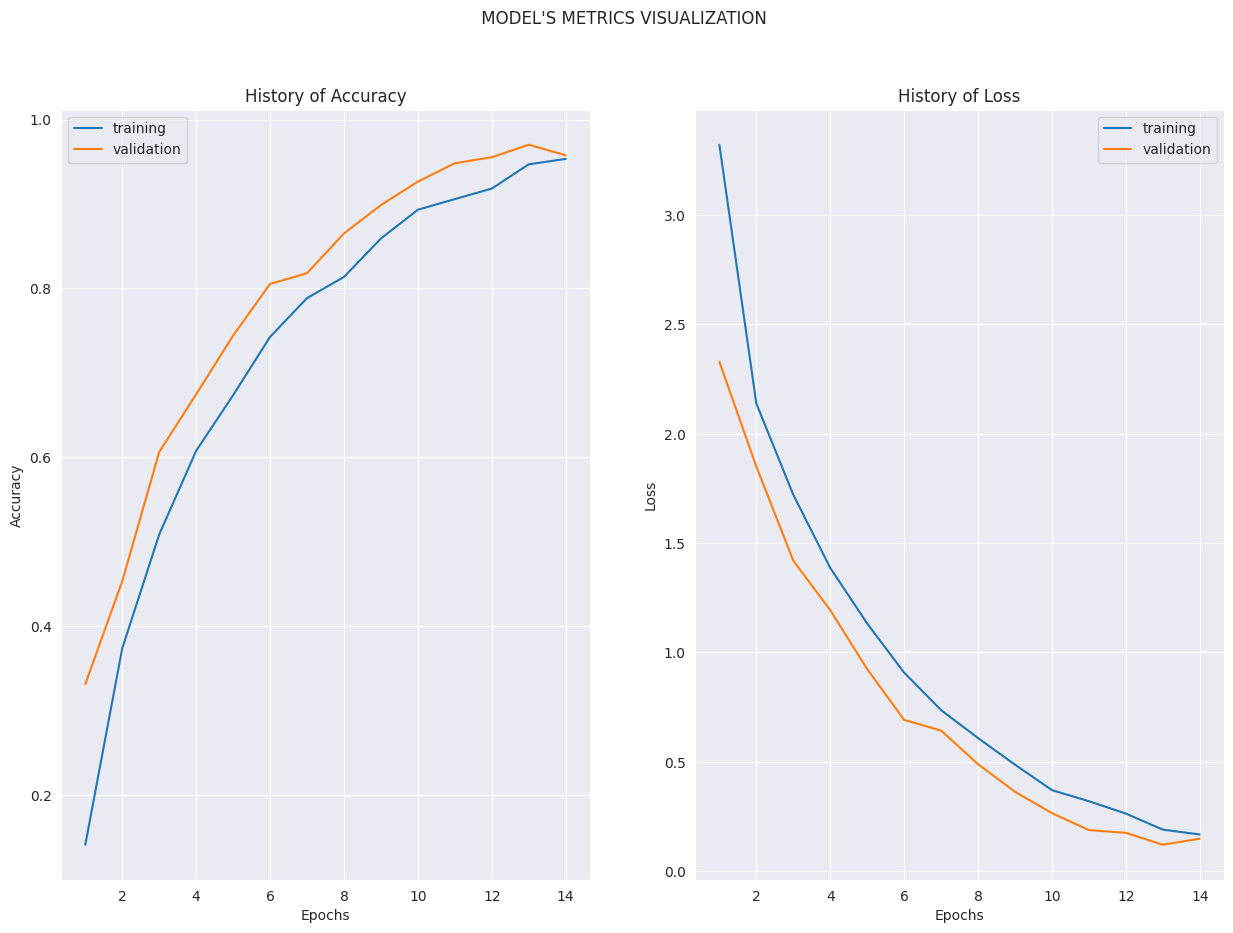

In [11]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history1.history['accuracy'],history1.history['val_accuracy'],
               history1.history['loss'],history1.history['val_loss'])

In [13]:
model.evaluate(x_test,y_test)

239/239 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9596 - loss: 0.1408


[0.1484757512807846, 0.9577649235725403]

## Konversi Model

### Model Keras H5

In [15]:
# Menyimpan model dalam format .keras
model.save('Cards_Image_Classification.h5')

In [16]:
import os

# Menentukan path tujuan untuk menyimpan model
target_dir = '/content/drive/MyDrive/Cards_Image_Classification'

# Membuat direktori tujuan jika belum ada
os.makedirs(target_dir, exist_ok=True)

# Menyimpan model dengan path lengkap
model_path = os.path.join(target_dir, 'Cards_Image_Classification.h5')
model.save(model_path)

In [17]:
import keras.saving

# Menyimpan model dalam format .keras
keras.saving.save_model(model, 'Cards_Image_Classification.keras')

In [18]:
import os

# Menentukan path tujuan untuk menyimpan model
target_dir = '/content/drive/MyDrive/Cards_Image_Classification/'

# Membuat direktori tujuan jika belum ada
os.makedirs(target_dir, exist_ok=True)

# Menyimpan model dengan path lengkap
model_path = os.path.join(target_dir, 'Cards_Image_Classification.keras')
model.save(model_path)

### Model TensorFlow.js

In [19]:
!tensorflowjs_converter --input_format keras \
                       /content/Cards_Image_Classification.h5 \
                       /content/Model_TFJS

2025-06-21 01:36:47.457072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750469807.482453   25619 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750469807.489647   25619 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [20]:
import shutil

# Path to the folder you want to zip
folder_path = './Model_TFJS'
output_path = './drive/MyDrive/Cards_Image_Classification/Model_TFJS'

# Create a ZIP file with the same name as the folder
zip_file = shutil.make_archive(output_path, 'zip', folder_path)

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/drive/MyDrive/Cards_Image_Classification/Model_TFJS.zip


### Model PB

In [21]:
import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model('/content/Cards_Image_Classification.h5')

# Convert and save the model to TensorFlow.js format
path = ('/content/Model_PB')
tf.saved_model.save(model,path)

In [22]:
import shutil

# Path to the folder you want to zip
folder_path = './Model_PB'
output_path = './drive/MyDrive/Cards_Image_Classification/Model_PB'

# Create a ZIP file with the same name as the folder
zip_file = shutil.make_archive(output_path, 'zip', folder_path)

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/drive/MyDrive/Cards_Image_Classification/Model_PB.zip


### Model TF-Lite

In [23]:
# Load model Keras
model = tf.keras.models.load_model('Cards_Image_Classification.h5')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan sebagai file .tflite
with open('/content/Cards_Image_Classification.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke .tflite")

Saved artifact at '/tmp/tmpmh6i10u6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 70, 70, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 53), dtype=tf.float32, name=None)
Captures:
  135092925640208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925636368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925637328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925639056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925639248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925639632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925640592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925637136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925638288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925635792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135092925638864:

In [24]:
import shutil

# Path ke file .tflite
file_path = '/content/Cards_Image_Classification.tflite'
zip_path = '/content/Cards_Image_Classification_tflite'

# Buat zip
zip_file = shutil.make_archive(zip_path, 'zip', root_dir='/content', base_dir='Cards_Image_Classification.tflite')

print(f'ZIP file created: {zip_file}')

ZIP file created: /content/Cards_Image_Classification_tflite.zip
